# Machine Learning Model Building Pipeline: Feature Engineering


## Predicting Rent Price of Houses

**Problem Statement:** To build an application which predicts the monthly rental of a house  based on different explanatory variables describing aspects of residential houses. 

**Data Source:** The dataset is received from the iNeuron ML Challenge 2 competition.

<hr>

**This is the notebook for step 2: Feature Engineering**

***NOTE***: As the dataset was of huge size, I choose not to push my dataset to Github, as I was facing some issues with Git LFS. Instead I uploaded it to Google Drive, here's the shared [link](https://drive.google.com/drive/folders/16n1lch7y9iVNdetydfwW7pa2s2Z-AINT?usp=sharing). One may download the dataset and save it in the dataset/ folder in this repo

## House Prices dataset: Feature Engineering

In the following cells, we will engineer / pre-process the variables of the House Rent Dataset from iNeuron. We will engineer the variables so that we tackle:

- [Data Cleaning](#Data-Cleaning)
    - Removing Outliers
    - Extracting new features
- [Missing values](#Missing-values)
- [Log transformation](#Numerical-variable-transformation)
- [Encoding Categorical Variables](#Categorical-Variables)


Let's go ahead and load the dataset.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv('dataset/housing_train.csv')
data.shape

(265190, 22)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
id                         265190 non-null int64
url                        265190 non-null object
region                     265190 non-null object
region_url                 265190 non-null object
price                      265190 non-null int64
type                       265190 non-null object
sqfeet                     265190 non-null int64
beds                       265190 non-null int64
baths                      265190 non-null float64
cats_allowed               265190 non-null int64
dogs_allowed               265190 non-null int64
smoking_allowed            265190 non-null int64
wheelchair_access          265190 non-null int64
electric_vehicle_charge    265190 non-null int64
comes_furnished            265190 non-null int64
laundry_options            210879 non-null object
parking_options            170055 non-null object
image_url                  265190 non-null objec

In [4]:
data.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,2.651900e+05,2.651900e+05,2.651900e+05,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,263771.000000,263771.000000
mean,7.040888e+09,1.227285e+04,1.093678e+03,1.912414,1.483468,0.716822,0.696550,0.733896,0.078759,0.014360,0.048644,37.208855,-92.398149
std,8.778930e+06,5.376352e+06,2.306888e+04,3.691900,0.630208,0.450543,0.459749,0.441920,0.269362,0.118968,0.215124,5.659648,17.370780
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000
25%,7.035963e+09,8.170000e+02,7.520000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.508500,-104.704000
50%,7.043109e+09,1.060000e+03,9.500000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.984900,-86.478300
75%,7.048362e+09,1.450000e+03,1.156000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.168400,-81.284600
max,7.051263e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000


## Data Cleaning

### **Removing outliers**

In EDA, we decided to remove outliers according to the upper and lower bound of its interquartile range.

In [5]:
def out_iqr(df , column):
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    return q75 + cut_off, 1

In [6]:
out_vars = ['price','sqfeet','beds','baths']

for var in out_vars:
    upper, lower = out_iqr(data, var)
    data = data[(data[var] <= upper) & (data[var] >= lower)]

In [7]:
data.shape

(228857, 22)

In [8]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

## Missing values

### Categorical variables

In [9]:
# make a list of the categorical variables that contain missing values
cat_var_na = ['laundry_options', 'parking_options', 'state']

In [10]:
def impute_missing_cat(data, var, modeof):
    return data.groupby(modeof)[var].transform(
        lambda x: x.fillna(x.mode()[0]))

In [11]:
data["laundry_options"] = impute_missing_cat(data, "laundry_options", "type")
data["parking_options"] = impute_missing_cat(data, "parking_options", "type")
data["state"] = impute_missing_cat(data, "state", "region")

### Numerical variables


In [12]:
# make a list with the numerical variables that contain missing values
num_var_na = ['lat', 'long']

In [13]:
data.drop(labels=num_var_na, axis=1, inplace=True)

Is there any remaining missing value ? 

In [14]:
#Check remaining missing values if any 
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
description,0.000874


In [15]:
data.drop(labels='description', axis=1, inplace=True)

In [16]:
#Check remaining missing values if any 
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [17]:
data.shape

(228857, 19)

## Numerical variable transformation

We will log transform the positive numerical variables in order to get a more Gaussian-like distribution. This tends to help Linear machine learning models. 

In [18]:
for var in ['price','sqfeet']:
    data[var] = np.log1p(data[var])

In [19]:
# check that data set does not contain null values in the engineered variables
[var for var in ['price','sqfeet'] if data[var].isnull().sum() > 0]

[]

## Categorical Variables

### Removing rare labels

First, we will group those categories within variables that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

In [20]:
# let's capture the categorical variables in a list

cat_vars = ['region', 'type', 'laundry_options', 'parking_options', 'state']

In [21]:
frequent_ls = {
    'region': 
        ['denver', 'fayetteville', 'jacksonville', 'omaha / council bluffs', 'rochester'],
     'type': 
        ['apartment', 'condo', 'duplex', 'house', 'manufactured', 'townhouse'],
     'laundry_options': 
        ['laundry in bldg', 'laundry on site', 'w/d hookups', 'w/d in unit'],  
     'parking_options': 
        ['attached garage', 'carport', 'detached garage', 'off-street parking', 'street parking'],
     'state': 
        ['al', 'ar', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 
        'ma', 'md', 'mi', 'mn', 'ms', 'nc', 'nd', 'ne', 'nj', 'nm', 'nv', 'ny', 'oh']
}


for var in cat_vars:
    data[var] = np.where(data[var].isin(
        frequent_ls[var]), data[var], 'Rare')

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. We will do it so that we capture the monotonic relationship between the label and the target.

In [22]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price


def replace_categories(data, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = data.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

In [23]:
for var in cat_vars:
    replace_categories(data, var, 'price')

In [24]:
# check absence of na in the train set
[var for var in data.columns if data[var].isnull().sum() > 0]

[]

In [25]:
data.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,state
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,4,https://bham.craigslist.org,7.021976,3,7.185387,3,2.0,1,1,1,0,0,0,1,0,https://images.craigslist.org/00707_uRrY9CsNMC...,7
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,4,https://bham.craigslist.org,6.716595,3,7.033506,1,1.5,1,1,1,0,0,0,1,1,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,7
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,4,https://bham.craigslist.org,6.685861,3,6.833032,1,1.0,1,1,1,0,0,0,1,1,https://images.craigslist.org/00808_6ghZ8tSRQs...,7
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,4,https://bham.craigslist.org,6.666957,3,6.954639,2,1.0,1,1,1,0,0,0,1,1,https://images.craigslist.org/00y0y_21c0FOvUXm...,7
5,7041966868,https://bham.craigslist.org/apa/d/birmingham-s...,4,https://bham.craigslist.org,6.803505,3,7.169350,2,2.0,1,1,1,0,0,0,1,1,https://images.craigslist.org/00606_g79izH5xxk...,7


In [26]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'state'],
      dtype='object')

In [27]:
features = ['region', 'price', 'type', 'sqfeet', 'beds', 'baths', 
            'cats_allowed', 'dogs_allowed', 'smoking_allowed',
            'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
            'laundry_options', 'parking_options', 'state']

data_final = data[features].copy()
data_final.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,state
1,4,7.021976,3,7.185387,3,2.0,1,1,1,0,0,0,1,0,7
2,4,6.716595,3,7.033506,1,1.5,1,1,1,0,0,0,1,1,7
3,4,6.685861,3,6.833032,1,1.0,1,1,1,0,0,0,1,1,7
4,4,6.666957,3,6.954639,2,1.0,1,1,1,0,0,0,1,1,7
5,4,6.803505,3,7.169350,2,2.0,1,1,1,0,0,0,1,1,7


In [28]:
for feature in features:
    data_final[feature] = data_final[feature].astype(np.float64)

### Correlation Heatmap

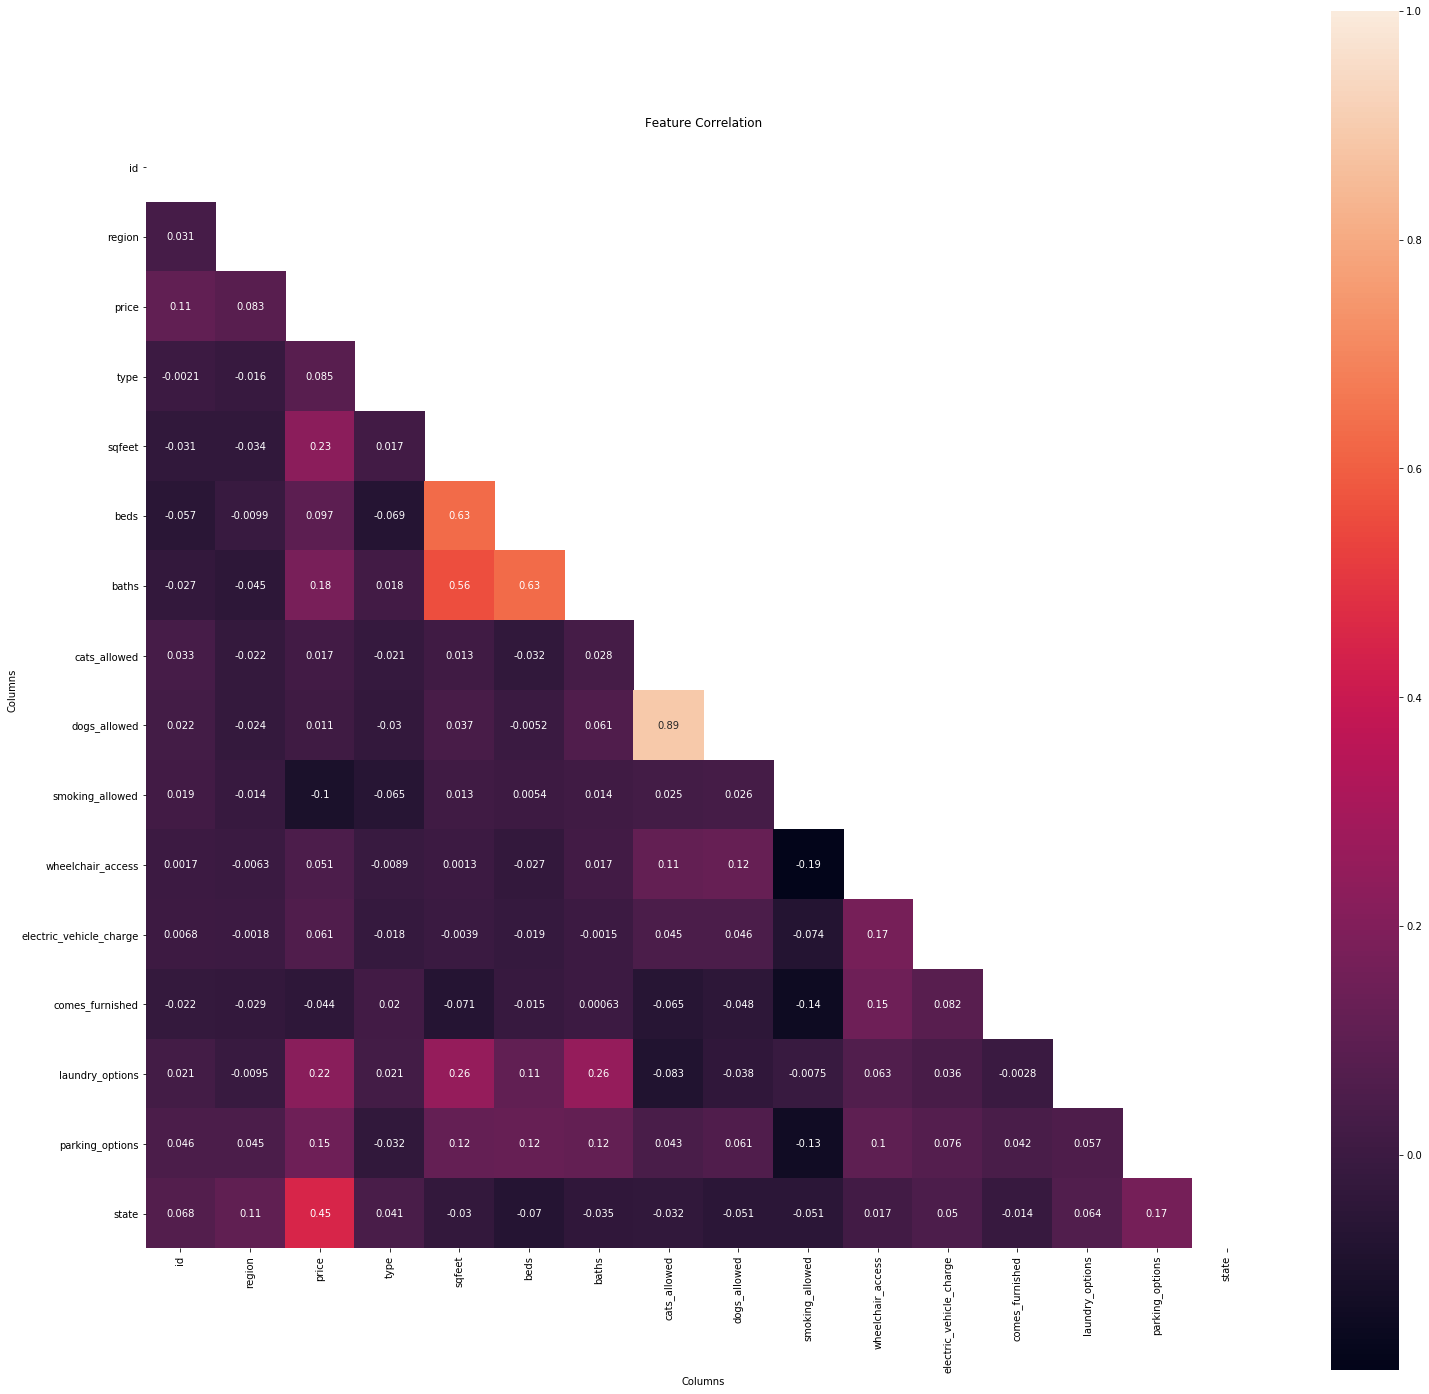

In [29]:
corr_matrix = data.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

fig, ax = plt.subplots(figsize=(25,25)) 

sns.heatmap(corr_matrix, 
            annot=True, 
            square=True,
            fmt='.2g',
            mask=mask,
            ax=ax).set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')

ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [30]:
data_final.to_csv('data_cleaned.csv', index=False)

In [31]:
data_final = pd.read_csv('data_cleaned.csv')
data_final.shape

(228857, 15)

In [32]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228857 entries, 0 to 228856
Data columns (total 15 columns):
region                     228857 non-null float64
price                      228857 non-null float64
type                       228857 non-null float64
sqfeet                     228857 non-null float64
beds                       228857 non-null float64
baths                      228857 non-null float64
cats_allowed               228857 non-null float64
dogs_allowed               228857 non-null float64
smoking_allowed            228857 non-null float64
wheelchair_access          228857 non-null float64
electric_vehicle_charge    228857 non-null float64
comes_furnished            228857 non-null float64
laundry_options            228857 non-null float64
parking_options            228857 non-null float64
state                      228857 non-null float64
dtypes: float64(15)
memory usage: 26.2 MB
